[*********************100%%**********************]  50 of 50 completed


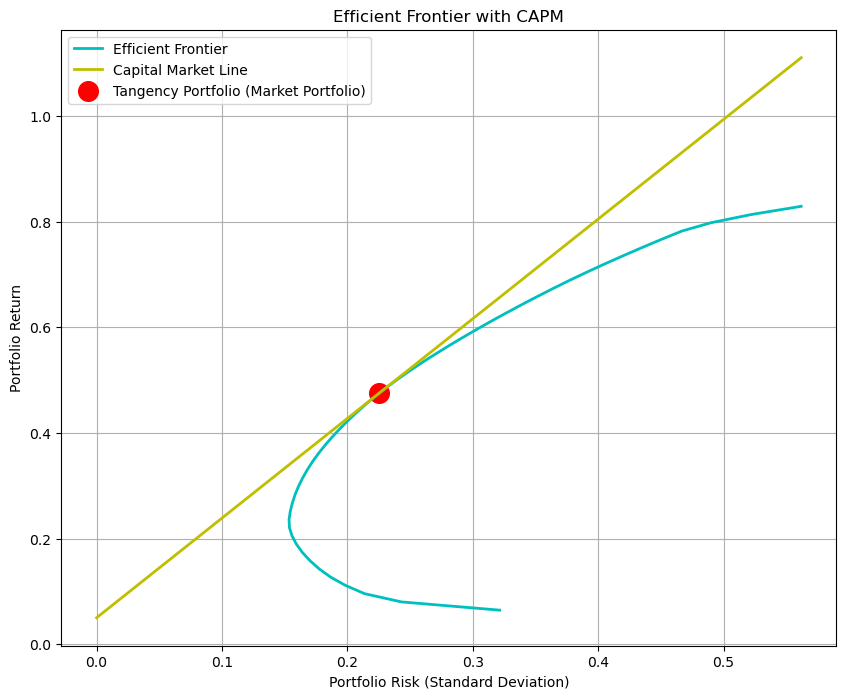

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf

# The following 50 stocks are Nifty 50 stocks.
ticker_set=[
    "ASIANPAINT.NS", "BRITANNIA.NS", "CIPLA.NS", "EICHERMOT.NS", "NESTLEIND.NS",
    "GRASIM.NS", "HEROMOTOCO.NS", "HINDALCO.NS", "HINDUNILVR.NS", "ITC.NS",
    "LT.NS", "M&M.NS", "RELIANCE.NS", "TATACONSUM.NS", "TATAMOTORS.NS",
    "TATASTEEL.NS", "WIPRO.NS", "APOLLOHOSP.NS", "DRREDDY.NS", "TITAN.NS",
    "SBIN.NS", "SHRIRAMFIN.NS", "BPCL.NS", "KOTAKBANK.NS", "INFY.NS",
    "BAJFINANCE.NS", "ADANIENT.NS", "SUNPHARMA.NS", "JSWSTEEL.NS", "HDFCBANK.NS",
    "TCS.NS", "ICICIBANK.NS", "POWERGRID.NS", "MARUTI.NS", "INDUSINDBK.NS",
    "AXISBANK.NS", "HCLTECH.NS", "ONGC.NS", "NTPC.NS", "COALINDIA.NS",
    "BHARTIARTL.NS", "TECHM.NS", "LTIM.NS", "DIVISLAB.NS", "ADANIPORTS.NS",
    "HDFCLIFE.NS", "SBILIFE.NS", "ULTRACEMCO.NS", "BAJAJ-AUTO.NS", "BAJAJFINSV.NS"
]
start_date = "2020-01-01"  #Date format is "YYYY-MM-DD"
end_date = "2024-01-01"

# Function to download stock data from Yahoo Finance
def download_stock_data(ticker_set, start_date, end_date):
    stock_data = yf.download(ticker_set, start=start_date, end=end_date)['Adj Close']
    stock_return=stock_data.pct_change().dropna()
    return stock_return
    
stock_return=download_stock_data(ticker_set, start_date, end_date)
returns=stock_return.mean()*252  # We assume 252 trading days in a year
cov_matrix=stock_return.cov()*252
num_assets = len(ticker_set)
risk_free_rate = 0.05  # Risk-free rate.

# Function for portfolio metrics
def portfolio_metrics(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return portfolio_return, portfolio_variance

# Objective function to minimize volatility
def minimize_volatility(weights, returns, cov_matrix):
    return portfolio_metrics(weights, returns, cov_matrix)[1]
    
# Objective function to maximize the Sharpe ratio (negative for minimization).
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return, portfolio_variance = portfolio_metrics(weights, returns, cov_matrix)
    portfolio_std= np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return -sharpe_ratio

# Constraints and bounds for the optimization
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Sum of weights is 1
bounds = tuple((0, 1) for asset in range(num_assets))  # Weights between 0 and 1

# Initial guess for weights (assume equal weights)
initial_value = [1 / num_assets]*num_assets

# Optimize for maximum Sharpe ratio (tangency portfolio)
result = minimize(negative_sharpe_ratio, initial_value, args=(returns, cov_matrix, risk_free_rate),
                  method='SLSQP', bounds=bounds, constraints=constraints)

tangency_weights = result.x  # Optimal weights for tangency portfolio
tangency_return, tangency_variance = portfolio_metrics(tangency_weights, returns, cov_matrix)
tangency_std_dev = np.sqrt(tangency_variance)

# Efficient Frontier calculation (risky assets only)
expected_returns = np.linspace(min(returns), max(returns), 50)
frontier_volatilities = []

for expected_return in expected_returns:
    constraints = ({'type': 'eq', 'fun': lambda weights: portfolio_metrics(weights, returns, cov_matrix)[0] - expected_return},
                   {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    result = minimize(minimize_volatility, initial_value, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
    frontier_volatilities.append(np.sqrt(result.fun))

# Capital Market Line (CML)
CML_x = np.linspace(0, max(frontier_volatilities), 100)
CML_y = risk_free_rate + ((tangency_return - risk_free_rate) / tangency_std_dev) * CML_x

# Plotting the Efficient Frontier and CML
plt.figure(figsize=(10, 8))
plt.plot(frontier_volatilities, target_returns, 'c-', linewidth=2, label='Efficient Frontier')
plt.plot(CML_x, CML_y, 'y-', linewidth=2, label='Capital Market Line')
plt.scatter(tangency_std_dev, tangency_return, c='r', marker='o', s=200, label='Tangency Portfolio (Market Portfolio)')
plt.title('Efficient Frontier with CAPM')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
print(f"Market portfolio return {tangency_return} and standard deviation {tangency_std_dev}")

Market portfolio return 0.47550169625282823 and standard deviation 0.22546384720716542
